In [1]:
import numpy as np
import plotly.graph_objects as go
import sys
import pandas as pd
import copy
from tqdm import tqdm
import cv2
sys.path.append("../")
from layers import get_layers
from states import States
import TD3
import utils
from hyperparameters import get_hyperparameters
from common import make_env, create_folders, make_env_cc

c:\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
env_name = "InvertedPendulum-v2"
p = 0.5
augment_type = "AsymTD3"
bests = []
lcs = []
for seed in range(10):
    arguments = [augment_type, env_name, seed]
    file_name = '_'.join([str(x) for x in arguments])
    total = np.load(f"../results/{file_name}.npy")
    lcs.append(total)
    bests.append(max(total))
# td3 = []   
# for seed in range(10):
#     arguments = [env_name, seed]
#     file_name = '_'.join([str(x) for x in arguments])
#     total = np.load(f"../results/{file_name}.npy")
#     td3.append(total)
    
lcs = np.array(lcs)
lcs = np.mean(lcs, axis=0)

# td3 = np.array(td3)
# td3 = np.mean(td3, axis=0)

In [8]:
np.mean(bests), np.std(bests)

(967.1600000000001, 44.814644927746556)

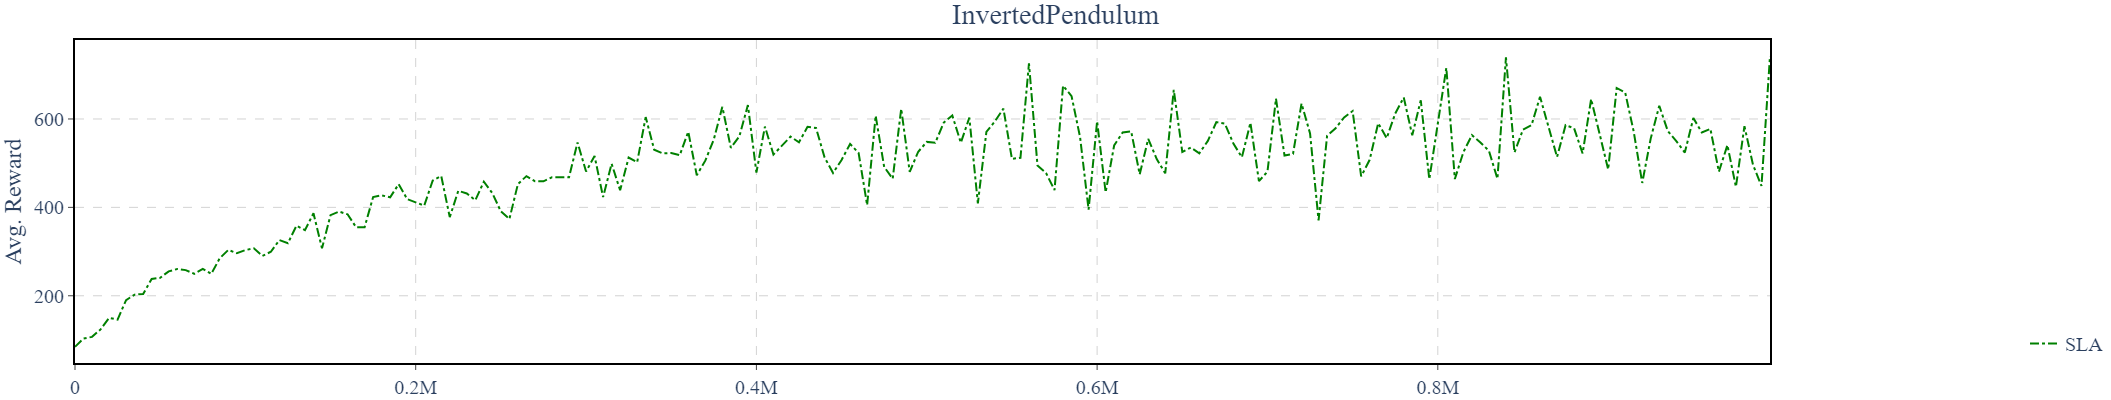

In [5]:
fig = go.Figure()

x = list(i*5000 for i in range(total.shape[0]))

fig.add_trace(go.Scatter(
    x=x, y=lcs,
    line_color='Green',
    name='SLA',
     line=dict(dash='dashdot', width=2)
))


# fig.add_trace(go.Scatter(
#     x=x, y=td3,
#     line_color='Blue',
#     name='TD3',
#     line=dict(width=2)
# ))


fig.update_layout(width=800, height=400,  
                  margin=dict(
        l=2,
        r=2,
        b=2,
        t=40,
        pad=0
    ), 
                  title={
        'text': "InvertedPendulum",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    , 
                  yaxis_title="Avg. Reward", 
                   font_family="Times New Roman",
                title_font_family="Times New Roman",
                  font_size=20,
                  legend=dict(
                        yanchor="bottom",
                        y=0.0,
                        xanchor="right",
                        x=1.2,
                    ), 
                  showlegend=True, plot_bgcolor = "white",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 200000,
        gridcolor="LightGrey",
        griddash="dash",
        mirror=True,
        ticks='outside',
        showline=True,
        linewidth=2,
        linecolor='black'
        
    ),  yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 200,
        gridcolor="LightGrey",
         griddash="dash",
                mirror=True,
        ticks='outside',
        showline=True,
        linewidth=2,
        linecolor='black'
    ))

In [12]:
env_name = "InvertedPendulum-v2"
layers = get_layers(env_name)
num_layers = layers['layers']
hy = get_hyperparameters(env_name)
timestep = hy['timestep']
env = make_env(env_name, 0, clock_wrapper=layers['clock'], clock_dim=layers['clock_dim'], prev_action_wrapper=layers['previous_action'])
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
kwargs = {"state_dim": state_dim, "action_dim": action_dim, "max_action": max_action, "discount": hy['discount'],
          "tau": hy['tau'],
          "policy_noise": hy['policy_noise'] * max_action, "noise_clip": hy['noise_clip'] * max_action,
          "policy_freq": hy['policy_freq'], "neurons": [400, 300]}

dfall = pd.DataFrame(columns=["seed", "noise", "avg. Reward"])

for seed in tqdm(range(10)):
    policies = []
    augment_type = "AsymTD3"
    arguments = [augment_type, env_name, seed]
    file_name = '_'.join([str(x) for x in arguments])
    k = copy.deepcopy(kwargs)
    k["removed_indices"] = layers['layer1']
    policy = TD3.TempoRLTLA(**k)
    policy.load(f"../models/{file_name}_best")


    env = make_env(env_name, seed, clock_wrapper=layers['clock'], clock_dim=layers['clock_dim'], prev_action_wrapper=layers['previous_action'])
    noise = i * 0.05
    eval_reward = 0
    for i in range(10):
        eval_state, eval_done = env.reset(), False
        while not eval_done:
            eval_action = policy.select_action(eval_state)
            eval_next_state, eval_r, eval_done, _ = env.step(eval_action)
            eval_reward += eval_r
            eval_state = eval_next_state

    avg_reward = eval_reward/10
    print(avg_reward)

 10%|████████████▏                                                                                                             | 1/10 [00:03<00:32,  3.57s/it]

945.2


 20%|████████████████████████▍                                                                                                 | 2/10 [00:07<00:28,  3.54s/it]

1000.0


 30%|████████████████████████████████████▌                                                                                     | 3/10 [00:10<00:23,  3.29s/it]

818.5


 40%|████████████████████████████████████████████████▊                                                                         | 4/10 [00:13<00:19,  3.22s/it]

838.9


 50%|█████████████████████████████████████████████████████████████                                                             | 5/10 [00:16<00:15,  3.20s/it]

971.3


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 6/10 [00:19<00:12,  3.16s/it]

880.3


 70%|█████████████████████████████████████████████████████████████████████████████████████▍                                    | 7/10 [00:21<00:08,  2.95s/it]

824.9


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8/10 [00:24<00:05,  2.88s/it]

953.2


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9/10 [00:27<00:02,  2.77s/it]

766.3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.08s/it]

1000.0
